# Data Processing

In this notebook we introduce the code we used to process all the data we have gathered from all scenes and their associated coverage maps

## Imports

In [22]:
import os

try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import tensorflow as tf
    import keras

except:
    os.system("pip install numpy")
    os.system("pip install pandas")
    os.system("pip install matplotlib")
    os.system("pip install seaborn")
    os.system("pip install tensorflow")
    os.system("pip install keras")

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import tensorflow as tf
    import keras

from matplotlib.backends.backend_pdf import PdfPages  # Import PdfPages

## Processing the extracted data

In [23]:

# Load dataset
file_path = "sionna_madrid/scene_charact_sionna_madrid_TENSOR_info_2025-05-15.csv"
df = pd.read_csv(file_path)

# let us get the maximum tot_building_area
max_row_tot_build_area = df.loc[df['tot_buildings_area'].idxmax()]
print(f"This is the max building area: {max_row_tot_build_area}")

# Identify variable types
variable_types = df.dtypes

# Identify columns with list-like structures
list_columns = [col for col in df.columns if df[col].dtype == 'object']

# Compute summary statistics for numerical columns
numerical_columns = [col for col in df.columns if col not in list_columns and col != 'scene_name']
summary_stats = df[numerical_columns].describe().T[['min', 'max', 'mean']]

# Compute correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Display results
print("\nVariable Types:")
print(variable_types)

print("\nColumns with List-like Structures (Excluded from Numerical Analysis):")
print(list_columns)

print("\nSummary Statistics for Numerical Columns:")
print(summary_stats)

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Define PDF file to save figures
pdf_path = "analysis_plots.pdf"
with PdfPages(pdf_path) as pdf:

    # Correlation Heatmap (Fits to Page)
    fig, ax = plt.subplots(figsize=(12, 10))  # Adjusted to fit page nicely
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
    ax.set_title("Correlation Matrix Heatmap")
    plt.tight_layout()  # Ensures everything fits within the figure
    pdf.savefig(fig, bbox_inches='tight')  # Save figure
    plt.close(fig)

    # Histograms for numerical columns (Adaptive Layout)
    cols_per_row = 3
    rows = (len(numerical_columns) + cols_per_row - 1) // cols_per_row  # Adaptive row count

    fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(8, rows * 3), constrained_layout=True)
    axes = axes.flatten()

    for i, col in enumerate(numerical_columns):
        df[col].hist(ax=axes[i], bins=100, edgecolor='black')
        axes[i].set_title(col, fontsize=10)
    
    # Hide empty subplots if any
    for i in range(len(numerical_columns), len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Distribution of Numerical Variables", fontsize=14)
    pdf.savefig(fig, bbox_inches='tight')  # Save figure
    plt.close(fig)

print(f"All figures saved to {pdf_path}")


This is the max building area: scene_name                                                2810061
scenes_size                        [400, 400, 14.028573036193848]
num_elements                                                    4
max_vertex_count                                              104
min_vertex_count                                                8
avg_vertex_count                                             40.0
tallest_building                                        14.028573
shortest_building                                        4.057104
avg_building_height                                      7.387985
tot_num_faces                                                 174
avg_num_faces_building                                       58.0
max_num_faces_building                                        154
tot_buildings_area                                   74904.959524
avg_building_area                                    24968.319841
max_building_area                            

## Let us do a more extensive analysis

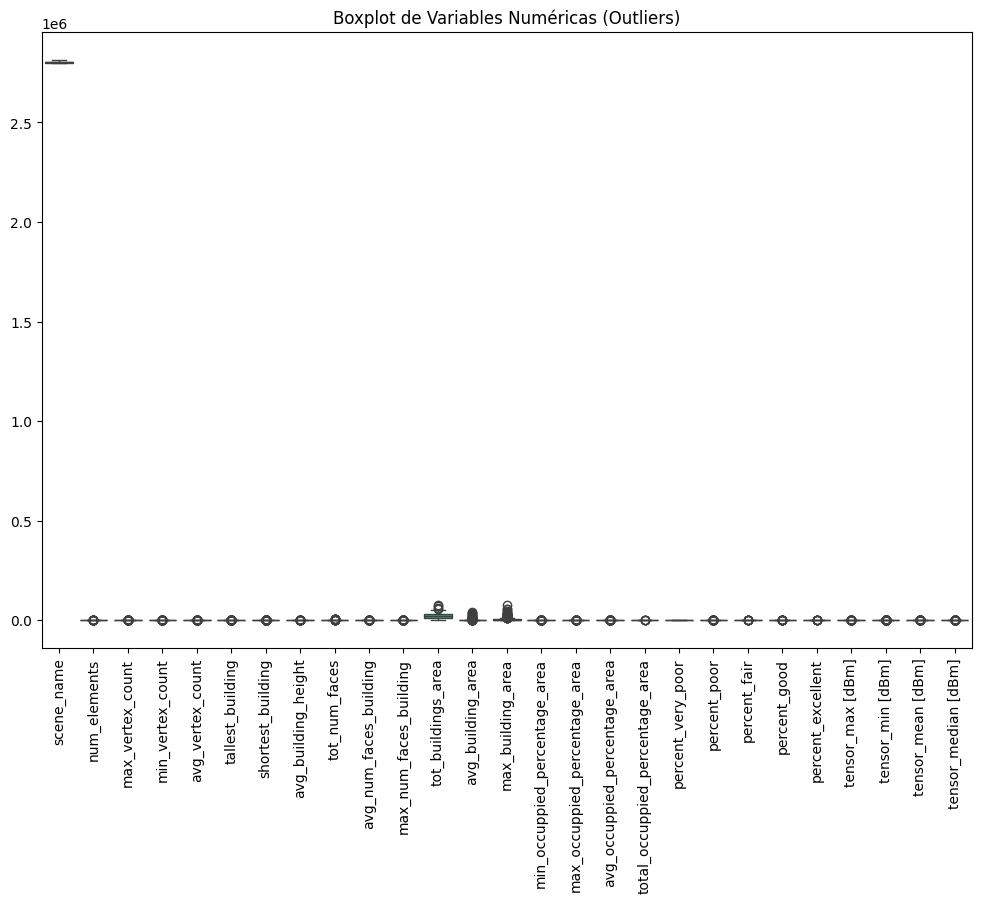

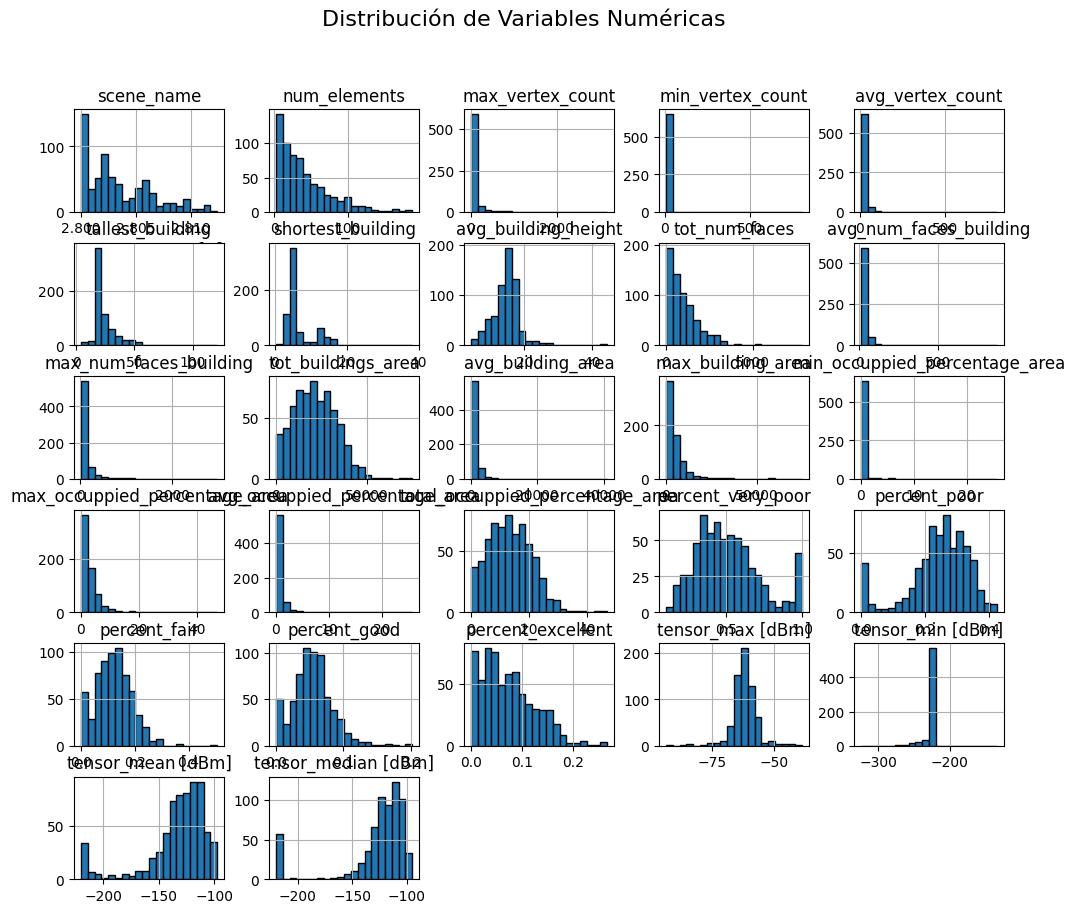

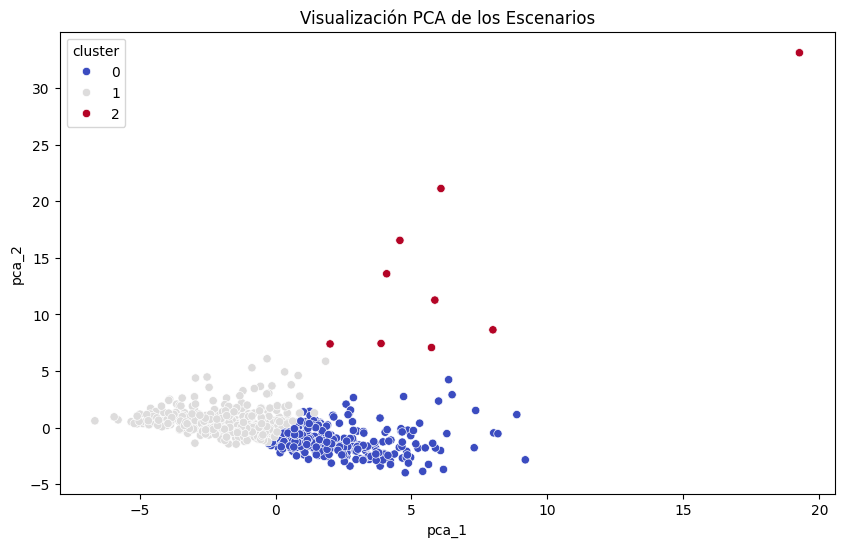

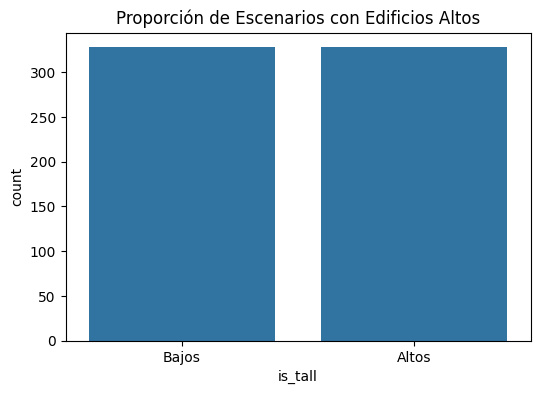

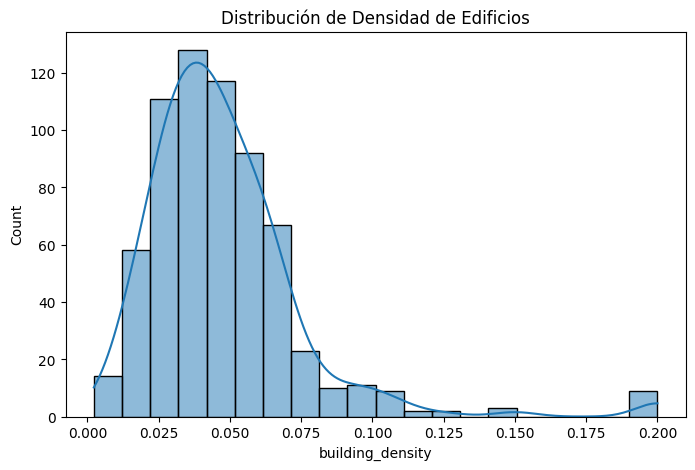


Datos Faltantes por Columna:
scene_name                           0
scenes_size                          0
num_elements                         0
max_vertex_count                     0
min_vertex_count                     0
avg_vertex_count                     0
tallest_building                     0
shortest_building                    0
avg_building_height                  0
tot_num_faces                        0
avg_num_faces_building               0
max_num_faces_building               0
tot_buildings_area                   0
avg_building_area                    0
max_building_area                    0
min_occuppied_percentage_area        0
max_occuppied_percentage_area        0
avg_occuppied_percentage_area        0
total_occuppied_percentage_area      0
percent_very_poor                    0
percent_poor                         0
percent_fair                         0
percent_good                         0
percent_excellent                    0
tensor_max [dBm]                  

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    from scipy.stats import skew, kurtosis
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
except:
    os.system("pip install seaborn")
    os.system("pip install scikit-learn")
    os.system("pip install sklearn")

    import seaborn as sns
    from scipy.stats import skew, kurtosis
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler

# Cargar dataset
file_path = "sionna_madrid/scene_charact_sionna_madrid_TENSOR_info_2025-05-15.csv"
df = pd.read_csv(file_path)

# Separar columnas numéricas y categóricas
list_columns = [col for col in df.columns if df[col].dtype == 'object']
numerical_columns = [col for col in df.columns if col not in list_columns]

# **Análisis Descriptivo y Outliers**
summary_stats = df[numerical_columns].describe().T[['min', 'max', 'mean']]
df['skewness'] = df[numerical_columns].apply(lambda x: skew(x))
df['kurtosis'] = df[numerical_columns].apply(lambda x: kurtosis(x))

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_columns])
plt.xticks(rotation=90)
plt.title("Boxplot de Variables Numéricas (Outliers)")
plt.show()

df[numerical_columns].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Distribución de Variables Numéricas", fontsize=16)
plt.show()

# **Variabilidad y Dispersión**
df['std_dev'] = df[numerical_columns].std()
df['cv'] = df[numerical_columns].std() / df[numerical_columns].mean()  # Coeficiente de variación
df['iqr'] = df[numerical_columns].quantile(0.75) - df[numerical_columns].quantile(0.25)  # Rango intercuartil

# **Clustering (K-Means)**
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_columns])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df_scaled)

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=df['max_building_volume'], y=df['tot_buildings_volume_max'], hue=df['cluster'], palette="viridis")
# plt.title("Clusters de Escenarios por Volumen de Edificios")
# plt.show()

# **Reducción de Dimensionalidad con PCA**
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['pca_1'], df['pca_2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['pca_1'], y=df['pca_2'], hue=df['cluster'], palette="coolwarm")
plt.title("Visualización PCA de los Escenarios")
plt.show()

# **Regresión Lineal Multivariable (Predicción de volumen máximo)**
X = df[['num_elements', 'max_vertex_count', 'avg_vertex_count']]
y = df['max_building_area']

reg = LinearRegression()
reg.fit(X, y)
df['predicted_area'] = reg.predict(X)

# plt.figure(figsize=(8, 5))
# sns.scatterplot(x=df['max_building_volume'], y=df['predicted_volume'])
# plt.xlabel("Volumen Real")
# plt.ylabel("Volumen Predicho")
# plt.title("Regresión Lineal: Predicción de Volumen Máximo de Edificio")
# plt.show()

# **Análisis de Proporciones de Edificios Altos vs Bajos**
df['is_tall'] = df['tallest_building'] > df['tallest_building'].median()

plt.figure(figsize=(6, 4))
sns.countplot(x=df['is_tall'])
plt.title("Proporción de Escenarios con Edificios Altos")
plt.xticks([0, 1], ['Bajos', 'Altos'])
plt.show()

# **Densidad de Edificios**
df['building_density'] = df['num_elements'] / df['tot_num_faces']

plt.figure(figsize=(8, 5))
sns.histplot(df['building_density'], bins=20, kde=True)
plt.title("Distribución de Densidad de Edificios")
plt.show()

# **Calidad del Dataset: Datos Faltantes y Duplicados**
missing_data = df.isnull().sum()
duplicates = df.duplicated().sum()

print(f"\nDatos Faltantes por Columna:\n{missing_data}")
print(f"\nNúmero de Filas Duplicadas: {duplicates}")

print("\n--- Análisis Completado ---")


## Tensor processing

In [13]:
datasets = ['sionna_madrid','sionna_madrid_concrete_ground']
test_max_min_mean = False
verbose = False

print(tf.__version__)
for directory in datasets:
    print(f"\nWe are now working in: {directory}")
    for name in os.listdir(directory):
        if verbose: print(f"Folder: {name}")
        if os.path.isdir(os.path.join(directory, name)) and name != ".ipynb_checkpoints":
            folder_path = os.path.join(directory, name)
            tensor_path = os.path.join(folder_path, "cm_tensor_dB.npy")
            print(folder_path)

        # Load the .npy file
        tensor = np.load(tensor_path)

        # Print the dimensions (shape)
        if verbose: print("Shape:", tensor.shape)

        # Print the number of dimensions
        if verbose: print("Number of dimensions:", tensor.ndim)

        # Print the data type
        if verbose: print("Data type:", tensor.dtype)

        # Print the actual values (consider slicing if large)
        if verbose: print("Values:", tensor)

        # let us iterate through the first 3 typical dimensions, corresponding to each antenna orientation
        if test_max_min_mean:
            for i in range(tensor.shape[0]):
    
                tensor_i = tensor[i]
                # let's get the mximum and the minimum within the given tensor
                tensor_max = tf.math.reduce_max(tensor_i, axis=None)
                tensor_min = tf.math.reduce_min(tensor_i, axis=None)
                tensor_mean = tf.math.reduce_mean(tensor_i, axis=None)
                tensor_squeeze = tf.squeeze(tensor_i) # now let us get the median
                tensor_median = np.median(tensor_squeeze.numpy())
    
                if verbose: print(f"Max tensor value (dBs) from all dimensions within the tensor: {tensor_max}")
                if verbose: print(f"Min tensor value (dBs) from all dimensions within the tensor: {tensor_min}")
                if verbose: print(f"Mean tensor value (dBs) from all dimensions within the tensor: {tensor_mean}")
                if verbose: print(f"Median tensor value (dBs) from all dimensions within the tensor: {tensor_median}")
                # print(f"Median tensor value (dBs) from all dimensions within the tensor: {tensor_median}")

        else:
            tensor_max = tf.math.reduce_max(tensor, axis=None)
            tensor_min = tf.math.reduce_min(tensor, axis=None)
            tensor_mean = tf.math.reduce_mean(tensor, axis=None)
            tensor_squeeze = tf.squeeze(tensor) # now let us get the median
            tensor_median = np.median(tensor_squeeze.numpy())
        
            if verbose: print(f"Max tensor value (dBs) from all dimensions within the tensor: {tensor_max}")
            if verbose: print(f"Min tensor value (dBs) from all dimensions within the tensor: {tensor_min}")
            if verbose: print(f"Mean tensor value (dBs) from all dimensions within the tensor: {tensor_mean}")
            if verbose: print(f"Median tensor value (dBs) from all dimensions within the tensor: {tensor_median}")

            

        

2.15.0

We are now working in: sionna_madrid
Folder: 2805598
sionna_madrid/2805598
Shape: (3, 1, 200, 200)
Number of dimensions: 4
Data type: float32
Values: [[[[-127.16867  -110.55098  -118.02908  ... -125.32333  -220.
    -220.      ]
   [-220.       -220.       -109.163895 ... -220.       -220.
    -124.660995]
   [-220.       -220.       -220.       ... -145.84062  -119.57567
    -119.91235 ]
   ...
   [-220.       -220.       -220.       ... -108.499954 -108.32028
    -108.52475 ]
   [-220.       -113.97214  -111.5282   ... -109.13515  -108.42389
    -109.09985 ]
   [-220.       -113.52986  -113.80704  ... -108.65108  -108.79849
    -108.64824 ]]]


 [[[-122.56868  -220.       -106.300125 ... -153.2094   -220.
    -143.9997  ]
   [-112.137726 -220.       -123.5983   ... -147.5122   -135.65788
    -153.07481 ]
   [-119.61899  -220.       -120.28859  ... -145.72687  -220.
    -146.00558 ]
   ...
   [ -81.94569   -84.69296  -220.       ... -116.857635 -117.24176
    -117.34886 ]
   [

## Another option

In [18]:
import numpy as np
import pandas as pd
import os
from datetime import date

# Your CSV dataset
datasets = ['sionna_madrid', 'sionna_madrid_concrete_ground']

for dataset in datasets:
    df = pd.read_csv(f'{dataset}/scene_charact_{dataset}2025-05-15.csv', sep=',')
    
    # Define bin edges and labels (in dBm)
    bins = [float('-inf'), -120, -100, -90, -80, float('inf')]
    labels = ['very_poor', 'poor', 'fair', 'good', 'excellent']
    
    # Add new columns if not already present
    for label in labels:
        if f'percent_{label}' not in df.columns:
            df[f'percent_{label}'] = np.nan
    
    for idx, row in df.iterrows():
        name = str(row['scene_name'])
        # Change to the actual path where your tensors are stored
        tensor_path = os.path.join(f'{dataset}', name, 'cm_tensor_dB.npy')
        if not os.path.exists(tensor_path):
            print(f"Tensor not found for scene {name}")
            continue
    
        # Load tensor (shape: 3,1,200,200)
        tensor = np.load(tensor_path)
        # Flatten all values for global statistics and binning
        values = tensor.flatten()
    
        # Tensor statistics
        tensor_tf = tf.convert_to_tensor(values)
        tensor_max = float(tf.reduce_max(tensor_tf).numpy())
        tensor_min = float(tf.reduce_min(tensor_tf).numpy())
        tensor_mean = float(tf.reduce_mean(tensor_tf).numpy())
        tensor_median = float(np.median(values))
    
        # Histogram for RSRP classes
        total_cells = values.size
        hist, _ = np.histogram(values, bins=bins)
        pct = hist / total_cells
    
        # Assign stats to DataFrame
        df.at[idx, 'tensor_max [dBm]'] = tensor_max
        df.at[idx, 'tensor_min [dBm]'] = tensor_min
        df.at[idx, 'tensor_mean [dBm]'] = tensor_mean
        df.at[idx, 'tensor_median [dBm]'] = tensor_median
        for l, v in zip(labels, pct):
            df.at[idx, f'percent_{l}'] = v
    
    # Save the enriched CSV
    df.to_csv(f'{dataset}/scene_charact_{dataset}_TENSOR_info_{date.today()}.csv', sep=',', index=False)
    print("CSV updated with RSS/RSRP classification percentages.")


CSV updated with RSS/RSRP classification percentages.
CSV updated with RSS/RSRP classification percentages.
